# Summarize Tool Differences

In the following notebook, we summarize the differences we calculated in `0.get-cytominer-tool-differences`.
We summarize the results in a series of visualizations and descriptive statistics.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import pathlib
import numpy as np
import pandas as pd
import plotnine as gg

from util import build_filenames

<IPython.core.display.Javascript object>

In [3]:
# Set constants
batch = "2016_04_01_a549_48hr_batch1"
input_dir = pathlib.Path("results", batch)
levels = ["level_3", "level_4a", "level_4b", "pycytominer_select"]
metrics = ["mean", "median", "sum"]

# Set output directory
output_fig_dir = pathlib.Path("figures", batch)
output_fig_dir.mkdir(parents=True, exist_ok=True)

# Set plotting defaults
dpi = 500
height = 3.5
width = 6

# Set common plotnine theme
theme_summary = gg.theme_bw() + gg.theme(
    axis_text_x=gg.element_blank(),
    axis_text_y=gg.element_text(size=6),
    axis_title=gg.element_text(size=8),
    strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
)

<IPython.core.display.Javascript object>

In [4]:
# Load Data
results_files = {}
for level in levels:
    file_names = build_filenames(input_dir, level=level)
    metric_df = {}
    for metric in file_names:
        df = pd.read_csv(file_names[metric], sep="\t", index_col=0)
        metric_df[metric] = df

    results_files[level] = metric_df

summary_file = pathlib.Path(f"{input_dir}/comparison_result_metric_summary.tsv")
summary_df = (
    pd.read_csv(summary_file, sep="\t", index_col=0)
    .sort_index()
    .reset_index()
    .rename({"index": "plate"}, axis="columns")
)

print(summary_df.shape)
summary_df.head()

(136, 10)


,plate,level_3_complete_mean_diff,level_3_complete_median_diff,level_3_complete_sum_diff,level_4a_complete_mean_diff,level_4a_complete_median_diff,level_4a_complete_sum_diff,level_4b_complete_mean_diff,level_4b_complete_median_diff,level_4b_complete_sum_diff
0,SQ00014812,0.001559,0.000486,1067.43526,0.004379,0.001440,2813.18178,0.003090,0.001475,412.86661
1,SQ00014813,0.001514,0.000482,1036.84789,0.011523,0.001931,7394.13258,0.004058,0.002029,545.46055
2,SQ00014814,0.001275,0.000498,872.86366,0.077055,0.001745,49502.69656,0.003597,0.001914,500.01469
3,SQ00014815,0.001422,0.000488,973.76201,0.009193,0.002450,5895.27801,0.002690,0.001521,362.53361
4,SQ00014816,0.001737,0.000500,1188.99632,0.008944,0.001521,5725.56706,0.002675,0.001683,338.91369


<IPython.core.display.Javascript object>

In [5]:
# Isolate the outlier plates that were processed by Cytominer in a different way
# See https://github.com/broadinstitute/lincs-cell-painting/issues/3#issuecomment-591994451
nonuniform_plates = summary_df.query("level_3_complete_median_diff > 1").plate.tolist()
nonuniform_plates

['SQ00015116',
 'SQ00015117',
 'SQ00015118',
 'SQ00015119',
 'SQ00015120',
 'SQ00015121',
 'SQ00015122',
 'SQ00015123',
 'SQ00015125',
 'SQ00015126']

<IPython.core.display.Javascript object>

In [6]:
# Since we know that these were processed differently, remove from the comparison
summary_df = summary_df.query("plate not in @nonuniform_plates").reset_index(drop=True)

<IPython.core.display.Javascript object>

In [7]:
# Ensure the plates are in order in each plot
plate_order = summary_df.plate.tolist()
summary_df.plate = pd.Categorical(
    summary_df.plate, categories=plate_order, ordered=True
)

<IPython.core.display.Javascript object>

In [8]:
# Process summary dataframe
summary_melted_df = []
for level in levels:
    # Summary for pycytominer select not shown to reduce comparison size
    if level == "pycytominer_select":
        continue
    for metric in metrics:
        col_name = f"{level}_complete_{metric}_diff"
        subset_df = (
            summary_df.loc[:, ["plate", col_name]]
            .assign(metric=metric, level=level)
            .rename({col_name: "metric_value"}, axis="columns")
        )
        summary_melted_df.append(subset_df)

summary_melted_df = pd.concat(summary_melted_df).reset_index(drop=True)
summary_melted_df = summary_melted_df.assign(uniform=True)
summary_melted_df.loc[
    summary_melted_df.plate.isin(nonuniform_plates), "uniform"
] = False

print(summary_melted_df.shape)
summary_melted_df.head()

(1134, 5)


,plate,metric_value,metric,level,uniform
0,SQ00014812,0.001559,mean,level_3,True
1,SQ00014813,0.001514,mean,level_3,True
2,SQ00014814,0.001275,mean,level_3,True
3,SQ00014815,0.001422,mean,level_3,True
4,SQ00014816,0.001737,mean,level_3,True


<IPython.core.display.Javascript object>

/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/summary_metrics_full.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


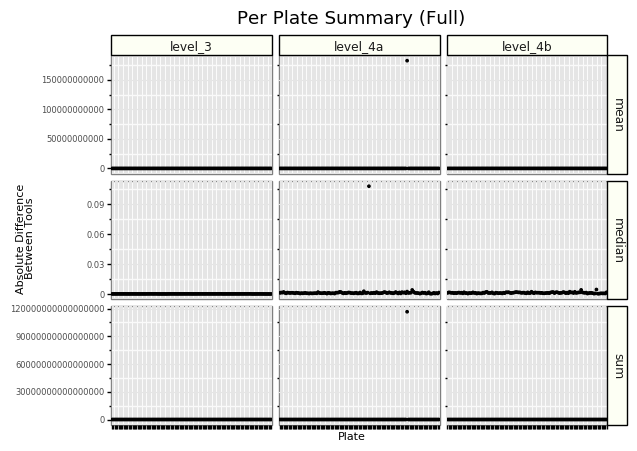

<ggplot: (308126021)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/summary_metrics_zoom.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


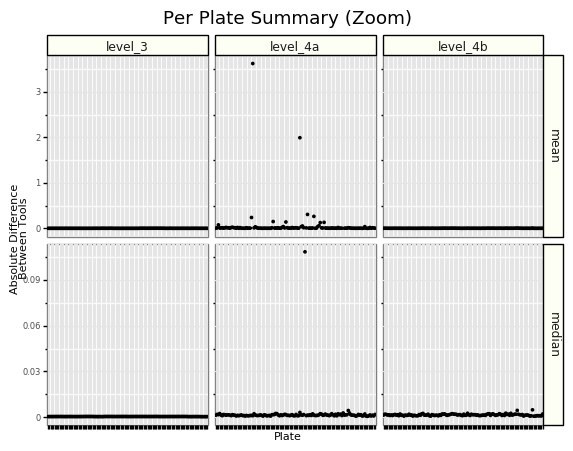

<ggplot: (309318073)>


<IPython.core.display.Javascript object>

In [9]:
summary_metric_full_gg = (
    gg.ggplot(summary_melted_df, gg.aes(x="plate", y="metric_value"))
    + gg.geom_point(size=0.5)
    + gg.facet_grid("metric~level", scales="free")
    + gg.xlab("Plate")
    + gg.ylab("Absolute Difference\nBetween Tools")
    + gg.ggtitle("Per Plate Summary (Full)")
    + theme_summary
)

output_file = pathlib.Path(f"{output_fig_dir}/summary_metrics_full.png")
summary_metric_full_gg.save(output_file, dpi=500, height=4, width=6)

print(summary_metric_full_gg)

summary_metric_zoom_gg = (
    gg.ggplot(
        summary_melted_df.query("metric_value < 10"),
        gg.aes(x="plate", y="metric_value"),
    )
    + gg.geom_point(size=0.5)
    + gg.facet_grid("metric~level", scales="free")
    + gg.xlab("Plate")
    + gg.ylab("Absolute Difference\nBetween Tools")
    + gg.ggtitle("Per Plate Summary (Zoom)")
    + theme_summary
)

output_file = pathlib.Path(f"{output_fig_dir}/summary_metrics_zoom.png")
summary_metric_zoom_gg.save(output_file, dpi=500, height=3.5, width=6)

print(summary_metric_zoom_gg)

In [10]:
# Wrangle output metric data to be plot ready
all_feature_results_df = []
for level in levels:
    for metric in metrics:
        plot_ready_df = (
            results_files[level][metric]
            .reset_index()
            .rename({"index": "feature"}, axis="columns")
            .melt(id_vars="feature", var_name="plate", value_name="metric_value")
            .assign(metric=metric, level=level)
        )
        all_feature_results_df.append(plot_ready_df)

all_feature_results_df = pd.concat(all_feature_results_df).reset_index(drop=True)

# Predetermine feature order
feature_order = sorted(list(set(all_feature_results_df.feature)))

all_feature_results_df = all_feature_results_df.assign(uniform=True)
all_feature_results_df.loc[
    all_feature_results_df.plate.isin(nonuniform_plates), "uniform"
] = False

all_feature_results_df.plate = pd.Categorical(
    all_feature_results_df.plate, categories=plate_order, ordered=True
)
all_feature_results_df.feature = pd.Categorical(
    all_feature_results_df.feature, categories=feature_order, ordered=True
)

# Select only the uniform plates
all_feature_results_df = all_feature_results_df.query("uniform")

print(all_feature_results_df.shape)
all_feature_results_df.head()

(2022678, 6)


,feature,plate,metric_value,metric,level,uniform
0,Cells_AreaShape_Area,SQ00015128,0.122396,mean,level_3,True
1,Cells_AreaShape_Center_X,SQ00015128,0.000000,mean,level_3,True
2,Cells_AreaShape_Center_Y,SQ00015128,0.000000,mean,level_3,True
3,Cells_AreaShape_Compactness,SQ00015128,0.000043,mean,level_3,True
4,Cells_AreaShape_Eccentricity,SQ00015128,0.000017,mean,level_3,True


<IPython.core.display.Javascript object>

## All Feature and Plate Summary

In [11]:
all_feature_results_df.groupby(["metric", "level"])["metric_value"].describe()

count      mean       std           min  \
metric level                                                            
mean   level_3             224658.0  0.001827  0.023633  0.000000e+00   
       level_4a            218212.0       inf       NaN  3.385417e-07   
       level_4b             41224.0  0.002979  0.015565  9.765625e-06   
       pycytominer_select   58905.0       inf       NaN  4.270833e-06   
median level_3             224658.0  0.000506  0.003214  0.000000e+00   
       level_4a            218212.0       inf       NaN  0.000000e+00   
       level_4b             41224.0  0.001624  0.008655  0.000000e+00   
       pycytominer_select   58905.0       inf       NaN  0.000000e+00   
sum    level_3             224658.0  0.701438  9.075099  0.000000e+00   
       level_4a            224658.0       inf       NaN  0.000000e+00   
       level_4b             41224.0  1.143822  5.977011  3.750000e-03   
       pycytominer_select   58905.0       inf       NaN  1.640000e-03   

                                    25%       50%       75%          max  
metric level                                                              
mean   level_3             2.604167e-08  0.000003  0.000026     3.163252  
       level_4a            2.500260e-04  0.000693  0.002196          inf  
       level_4b            2.751237e-04  0.000688  0.001955     1.816642  
       pycytominer_select  2.859635e-04  0.000721  0.002122          inf  
median level_3             0.000000e+00  0.000000  0.000020     0.040315  
       level_4a            1.600000e-04  0.000390  0.001075          inf  
       level_4b            1.900000e-04  0.000440  0.001140     1.191310  
       pycytominer_select  2.000000e-04  0.000450  0.001205          inf  
sum    level_3             1.000000e-05  0.001210  0.009810  1214.688770  
       level_4a            8.670500e-02  0.250910  0.807738          inf  
       level_4b            1.056375e-01  0.264185  0.750597   697.590400  
       pycytominer_select  1.097900e-01  0.276740  0.814890          inf

<IPython.core.display.Javascript object>

## Generate Two Figures Per Data Level

Split into different cells to prevent kernel death.

/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_3/level_3_metrics_per_plate.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


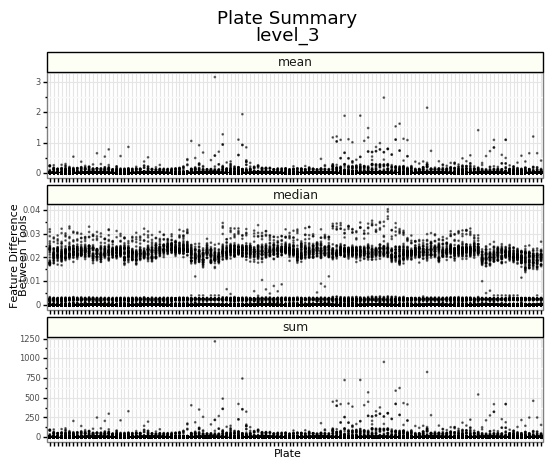

<ggplot: (330473625)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_4a/level_4a_metrics_per_plate.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12892 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12892 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


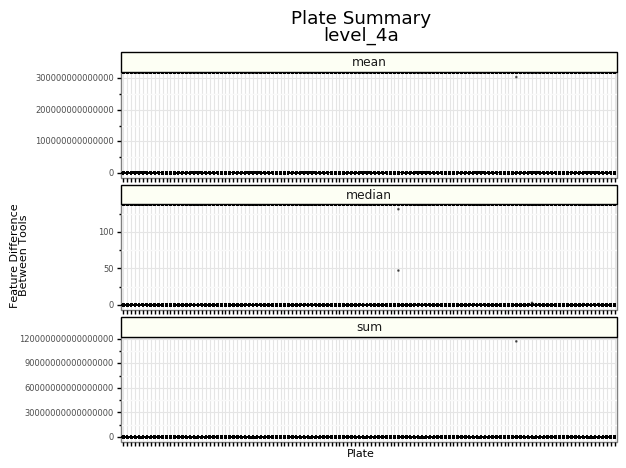

<ggplot: (328155873)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_4b/level_4b_metrics_per_plate.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 92922 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 92922 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


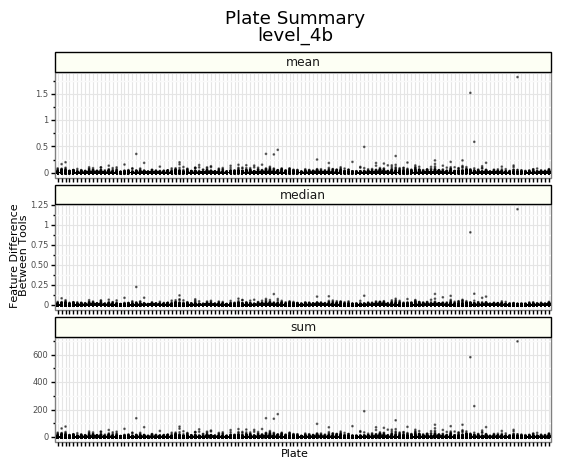

<ggplot: (330063389)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/pycytominer_select/pycytominer_select_metrics_per_plate.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 281421 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 281421 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


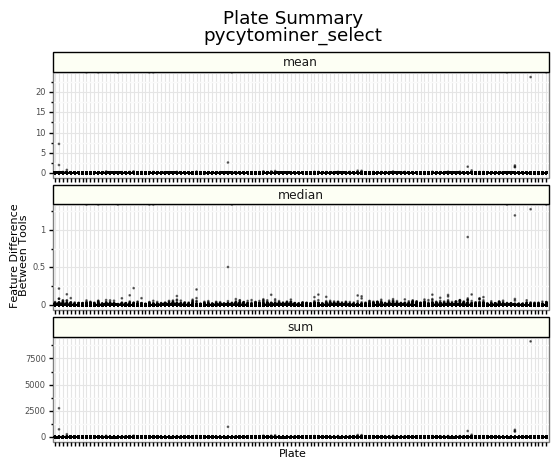

<ggplot: (280833477)>


<IPython.core.display.Javascript object>

In [12]:
for level in levels:
    all_feature_results_subset_df = all_feature_results_df.query(
        "level == @level"
    ).reset_index(drop=True)

    output_dir = pathlib.Path(f"{output_fig_dir}/{level}")
    output_dir.mkdir(exist_ok=True)

    # Figure 1 - Per plate feature differences
    per_plate_feature_gg = (
        gg.ggplot(all_feature_results_subset_df, gg.aes(x="plate", y="metric_value"))
        + gg.geom_point(size=0.1, alpha=0.5)
        + gg.facet_wrap("~metric", scales="free", nrow=len(metrics))
        + gg.xlab("Plate")
        + gg.ylab("Feature Difference\nBetween Tools")
        + gg.ggtitle(f"Plate Summary\n{level}")
        + theme_summary
    )

    output_file = pathlib.Path(f"{output_dir}/{level}_metrics_per_plate.png")
    per_plate_feature_gg.save(output_file, dpi=dpi, height=height, width=width)

    print(per_plate_feature_gg)
    del per_plate_feature_gg

/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_3/level_3_metrics_per_feature.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


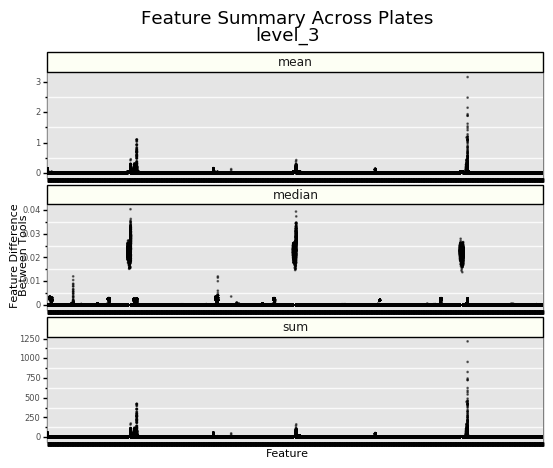

<ggplot: (310598569)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_4a/level_4a_metrics_per_feature.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12892 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 12892 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


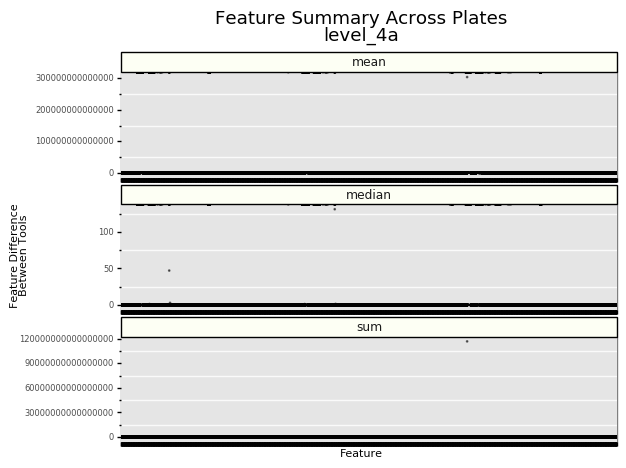

<ggplot: (336473137)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/level_4b/level_4b_metrics_per_feature.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 92922 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 92922 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


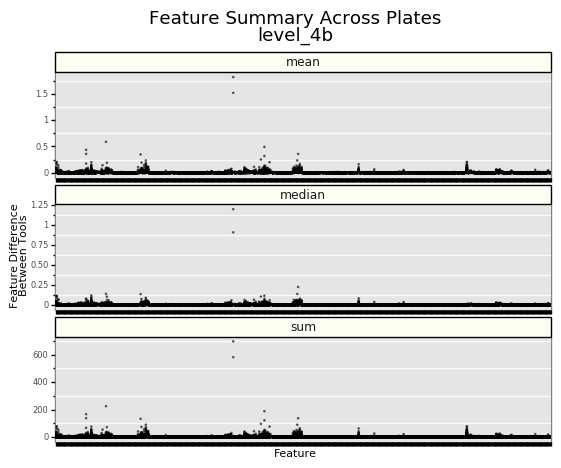

<ggplot: (310460913)>


/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 3.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/pycytominer_select/pycytominer_select_metrics_per_feature.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 281421 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 281421 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


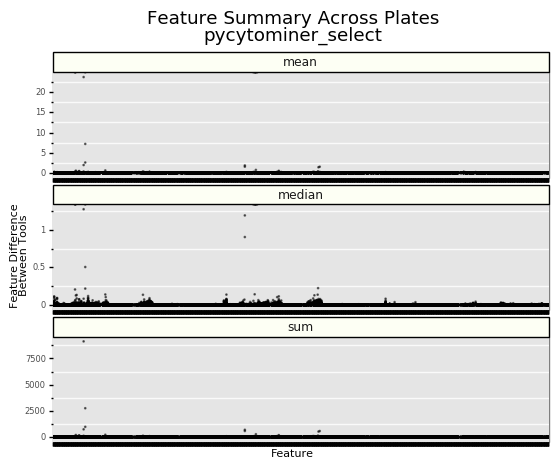

<ggplot: (331283569)>


<IPython.core.display.Javascript object>

In [13]:
for level in levels:
    all_feature_results_subset_df = all_feature_results_df.query(
        "level == @level"
    ).reset_index(drop=True)

    output_dir = pathlib.Path(f"{output_fig_dir}/{level}")
    output_dir.mkdir(exist_ok=True)

    # Figure 2 - Per feature plate differences
    per_feature_gg = (
        gg.ggplot(all_feature_results_subset_df, gg.aes(x="feature", y="metric_value"))
        + gg.geom_point(size=0.1, alpha=0.5)
        + gg.facet_wrap("~metric", scales="free", nrow=len(metrics))
        + gg.xlab("Feature")
        + gg.ylab("Feature Difference\nBetween Tools")
        + gg.ggtitle(f"Feature Summary Across Plates\n{level}")
        + theme_summary
    )

    output_file = pathlib.Path(f"{output_dir}/{level}_metrics_per_feature.png")
    per_feature_gg.save(output_file, dpi=dpi, height=height, width=width)

    print(per_feature_gg)
    del per_feature_gg

## Feature Selection Summary

In [14]:
# Load data
select_file = pathlib.Path(f"{input_dir}/comparison_result_4b_feature_select.tsv.gz")
select_df = (
    pd.read_csv(select_file, sep="\t", index_col=0)
    .reset_index()
    .rename({"index": "feature"}, axis="columns")
    .melt(id_vars="feature", var_name="plate", value_name="status")
    .query("plate not in @nonuniform_plates")
)

# Reorder data
select_df.plate = pd.Categorical(select_df.plate, categories=plate_order, ordered=True)
select_df.feature = pd.Categorical(
    select_df.feature, categories=feature_order, ordered=True
)

print(select_df.shape)
select_df.head()

(224658, 3)


,feature,plate,status
0,Cytoplasm_Correlation_RWC_ER_AGP,SQ00015128,only_pycytominer
1,Nuclei_Intensity_MADIntensity_AGP,SQ00015128,only_cytominer
2,Nuclei_Granularity_15_AGP,SQ00015128,missing
3,Nuclei_Texture_SumAverage_AGP_10_0,SQ00015128,missing
4,Cytoplasm_Correlation_Overlap_DNA_ER,SQ00015128,present_both


<IPython.core.display.Javascript object>

/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/gway/miniconda3/envs/lincs/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/feature_select_summary.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


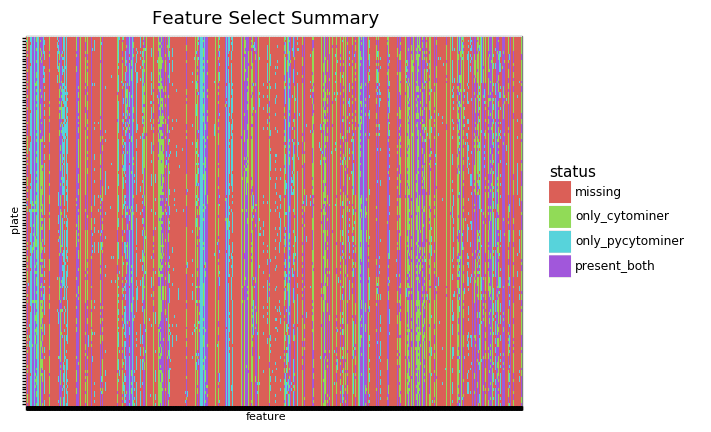

<ggplot: (349772973)>

<IPython.core.display.Javascript object>

In [15]:
feature_select_gg = (
    gg.ggplot(select_df, gg.aes(x="feature", y="plate", fill="status"))
    + gg.geom_tile(size=0.5)
    + gg.ggtitle("Feature Select Summary")
    + theme_summary
    + gg.theme(axis_text_y=gg.element_blank())
)

output_file = pathlib.Path(f"{output_fig_dir}/feature_select_summary.png")
feature_select_gg.save(output_file, dpi=dpi, height=4, width=6)

feature_select_gg